# <font color=cyan> Two ways of exporting Third-Parties </font>

The main goal of this Sample is to compare the results retrieved by **Process Templates** and **Third Parties** APIs and show that the data for both is the same. An additional functionality of this Sample is the possibility to retrieve third parties through both APIs. The exported results are then displayed through **CSV** format.

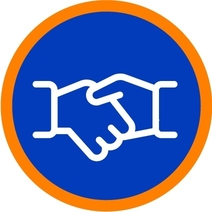

## <font color='yellow'>Code for token generation and API 


In [ ]:
#@title Select **servicePack** the Sample should run
from subprocess import getstatusoutput
servicePack = "DEMO" #@param ['DEMO'] {allow-input: true}

if servicePack == 'DEMO':
  branch = 'main'
else:
  branch = servicePack
print(branch)
rm = getstatusoutput("rm Colab_shared_code_for_API_usage -rf ") 
clone = getstatusoutput("git clone -l -s --branch " +  branch + " https://github.com/kyriba/Colab_shared_code_for_API_usage.git") 
import importlib
try:  
  importlib.reload(sample_requests)
except:
  print()
from Colab_shared_code_for_API_usage import sample_requests


In [ ]:
#@title Import custom modules
import numpy as np




## <font color='yellow'>Tools for working with result</font>



In [1]:
#@title Compare results

#@markdown Function to compare two dataFrames. Result is true if both have the same number of rows and second dataFrame contains all Codes from first dataFrame. 
def compare_results(df1, df2):
  if not df1.shape[0] == df2.shape[0]:
    print('Results are different:\n',df1.shape[0], 'items returned by Third Party API \n vs\n',df2.shape[0], 'items returned by Process Template API') 
  else:
    if df1['Code'].isin(df2['code']).all():
      print('Results:\n',df1.shape[0], 'items returned by Third Parties API \n vs\n',df2.shape[0], 'items returned by Process Templates API')
      print('')
      print('Comparison complete, results from both APIs match')
    else: print('Comparison complete, results are different')

In [2]:
#@title Show results
#@markdown Function to display table with results.

def show_results(df):
  df2 = sample_requests.copy.deepcopy(df)
  df2.replace(np.nan, '-', inplace = True)
  display(df2)
 

## <font color='yellow'>Connect and retrieve token</font>

In [ ]:
#@title <font color='lime'>Connect</font>
print('token:')
token = sample_requests.login()

## <font color=yellow>Exporting third-parties

In [ ]:
#@title <font color='lime'>Launch and Compare Third Parties and Process Templates reports</font>

# get report from Process Template
res1 = sample_requests.run_report(token,'SU11')
buffer = sample_requests.StringIO(res1)
# list of columns to display results from ProcessTemplates
colunmsPT = ['Code', 'Name', 'Country code', "Limit currency"]
# read and map result
df1 = sample_requests.pd.read_csv (buffer, delimiter = ";", header=None)
sample_requests.pd.set_option('display.max_colwidth', None)
df1.columns = df1.loc[0]
df1 = df1.loc[1:,:]
df1 = df1[colunmsPT]
df1.drop_duplicates(subset=['Code'], inplace = True, ignore_index= True)

# get all third parties in json 
res2 = sample_requests.get_results(token, '/v1/third-parties')
ppjson = sample_requests.js.loads(res2, parse_int=int) 
# list of columns to display results from Third Parties
colunmsTP = ['uuid', 'code', 'name', 'creationDate', 'activeStatus']  
# convert json to dataFrame
df2 = sample_requests.pd.json_normalize(ppjson['results']).filter(items=['uuid', 'code', 'name', 'creationDate', 'updateDate', 'activeStatus', 'businessIdentifiers.otherIdentifierType', 'address.country.code'], axis =1)
# check if next page is present. 
# Get results and append to previous unless next is absent.
while True:
  try:
    next = ppjson['metadata']['links']['next']
    res2 = sample_requests.get_results(token, '/v1/third-parties' + next[next.index('?'):])
    ppjson = sample_requests.js.loads(res2, parse_int=int)  
    df2 = df2.append(sample_requests.pd.json_normalize(ppjson['results']).filter(items=['uuid', 'code', 'name', 'creationDate', 'updateDate', 'activeStatus', 'businessIdentifiers.otherIdentifierType', 'address.country.code'], axis =1), ignore_index = True)
  except:
    break
df2 = df2[colunmsTP]

# call function to compare results
compare_results(df1, df2)


In [ ]:
#@title <font color='lime'>Show retrieved Process Templates results</font>

#@markdown Select number of rows to display:
rows = "10" #@param [10, 20, 50, 100, "showAll"] {allow-input: true}

# check if input is correct and print results
# corresponding to input value
if (rows.isdigit() or rows == 'showAll') :
    print('Results from process template: ')
    if rows == 'showAll':
      show_results(df1)
      print('Dispalyed results: ' + str(df1.shape[0]))
    else: 
      show_results(df1.head(int(rows))) 
      rows_display = rows if int(rows) < df1.shape[0] else str(df1.shape[0])
      print('Displayed results: ' + rows_display )
    print('Total results: ' + str(df1.shape[0]))
else:
  print("rows should be integer")



In [ ]:
#@title <font color='lime'>Show retrieved Third Parties results</font>

#@markdown Select number of rows to display:
rows = "10" #@param [10, 20, 50, 100, "showAll"] {allow-input: true}
# check if input is correct and print results
# corresponding to input value
if (rows.isdigit() or rows == 'showAll') :
    print('Results from third parties: ')
    if rows == 'showAll':
      show_results(df2)
      print('Dispalyed results: ' + str(df2.shape[0]))
    else: 
      show_results(df2.head(int(rows))) 
      rows_display = rows if int(rows) < df2.shape[0] else str(df2.shape[0])
      print('Displayed results: ' + rows_display )
    print('Total results: ' + str(df2.shape[0]))
else:
  print("rows should be integer")

## <font color='yellow'>Kyriba APIs: build your future</font>

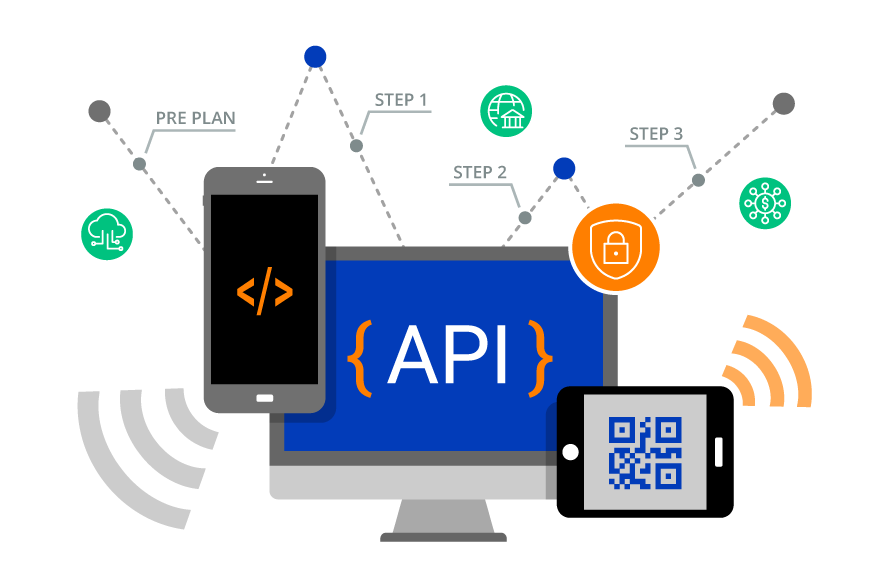